<a id='section_id3'></a>
# Wasserstoffverkauf

Statt den überschüssigen PV-Strom einzuspeisen oder zu speichern ist auch der Betrieb eines Elektrolyseurs und Verkauf des Wassertstoffs denkbar. Dieses Konzept wird in diesem Notebook untersucht.

\
Verwendete Skripte:\
[Parameter Base Case](parameter_base_case.py)\
[Hilfsfunktionen](own_utility_functions.py)\
[Visualisierung](visualisation.py)\
[Speicher](speicher.py)



## Initialisierung

In [1]:
from parameter_base_case import *
Nummer = '31' 

directory = directory_data+'Lastprofil_' + Nummer +'.npy'
with open(directory, 'rb') as f:
    [P_verbraucher, P_pv, P_dif, P_def, P_ueber] = np.load(f)

E_verbraucher = jahresenergie_kWh(P_verbraucher)
E_pv = jahresenergie_kWh(P_pv)
E_def = jahresenergie_kWh(P_def)
E_ueber = jahresenergie_kWh(P_ueber)

#Zeitausschnitte für Visualisierung
days = timeline.minute_period('2019-09-22','2019-09-25')
year = timeline.minute_period('2019-01-01','2019-12-31')
year_dayres = timeline.day_period('2019-01-01','2019-12-31')

In [2]:
##Histogramm Überproduktion erstellen
upperlim=8000
bins, n, ax = vis.histogram(np.arange(1,upperlim,20),P_ueber,'Leistung in Watt','Häufigkeit in Minuten',\
                        'Histogram Verteilung der Überschussleistung (ganzes Jahr)')

##Häufigkeit über Leistung aufintegrieren --> Energie
integral=np.zeros(np.size(n))
for i, value in enumerate(n):
    if i>0:
        integral[i]=integral[i-1]+average(bins[i],bins[i-1])*value/1000/60
##Bei Überschreiten der Max-Leistung wird mit Max-Leistung weitergearbeitet und nicht abgeschaltet        
for i, value in enumerate(n):    
    integral[i]=integral[i]+np.sum(n[i:np.size(n)])*bins[i]/60/1000
##Ergebnis    
P_RFC_charge_max_array=bins[1:np.size(bins)]
E_h2=integral*eff_elektrolyse


ax=vis.plot(P_RFC_charge_max_array/1000, E_h2, 'Maximalleistung Elektrolyseur in kW', \
         'Überschussenergie in kWh', 'Einfluss Elektrolyseur Größe auf Erzeugung von Wasserstoff')
vis.addtoplot(ax,[0, upperlim/1000],[E_ueber,E_ueber],['E Wasserstoff eingespeichert','theoretisch ges. verfügbar '+"%4.0f" % E_ueber +'kWh'])
#vis.save_to_tex('diagramm_speichermaxleistung_einspeichermenge',ax)
P_RFC_charge_max_array=P_RFC_charge_max_array-P_RFC_charge_max_array[0]
E_h2=E_h2-E_h2[0]


In [3]:
def gasflaschenmonitor(E_h2_array, flaschenkapazitaet,year):
    step=0
    flaschenfuellung=np.zeros(len(E_h2_array))
    z=1
    for i,value in enumerate(E_h2_array):
        if value>flaschenkapazitaet*z:
            z=z+1
            print('Abholung Nr',z-1,'am',year[i])
        flaschenfuellung[i]=E_h2_array[i]-flaschenkapazitaet*(z-1)  
    return flaschenfuellung

## Beispiel mit 2kW Elektrolyseur

Kapazität pro Bündel 360.0 kWh

Abholung Nr 1 am 2019-03-05T08:35
Abholung Nr 2 am 2019-04-11T08:07
Abholung Nr 3 am 2019-05-12T09:35
Abholung Nr 4 am 2019-06-10T11:39
Abholung Nr 5 am 2019-07-08T11:25
Abholung Nr 6 am 2019-08-09T08:29
Abholung Nr 7 am 2019-09-07T15:43
Abholung Nr 8 am 2019-10-17T14:36


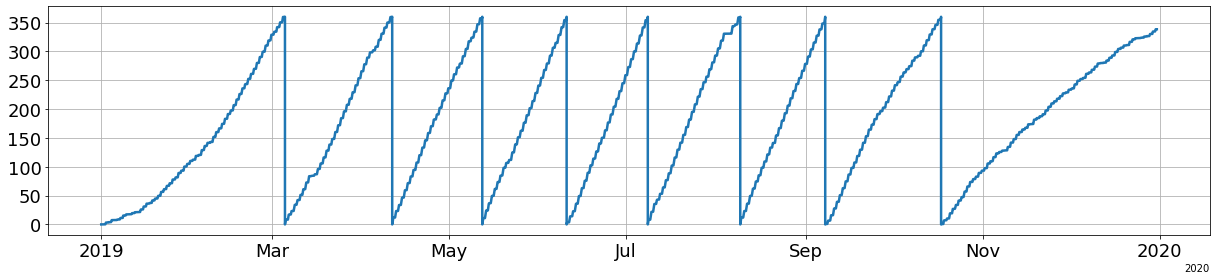

In [4]:
E_h2_array, P_elektrolyse_array=speicher.P2G_lastprofile(P_ueber, 2000, eff_elektrolyse)
vis.plot_timeline(year,E_h2_array,'Energie in kWh','In Wasserstoff gespeicherte Energie im Jahresverlauf')

#50 Liter Flasche mit 200 Bar in Bündeln mit 12 Flaschen
flaschenkapazitaet=50*200*0.003*12
print('Kapazität pro Bündel',flaschenkapazitaet, 'kWh\n')
flaschenfuellung=gasflaschenmonitor(E_h2_array, flaschenkapazitaet, year)
vis.plot_timeline(year,flaschenfuellung,'','')

